# **Tugas 3 Deep Learning — Model Transformer untuk Klasifikasi Ulasan Aplikasi Dana di Playstore**

**Kelompok 66**

Nama Anggota:

Muhamad Khafabillah Sopian (2307824)

Abyan Laksono (2304127)

Mata Kuliah: Deep Learning

Semester: 5 — Universitas Pendidikan Indonesia



---



**Setup Awal dan Import Library**

Tahap ini bertujuan untuk impor pustaka yang dibutuhkan.
Selain itu, nilai seed juga ditetapkan agar seluruh proses acak (seperti pembagian data dan inisialisasi bobot) menghasilkan hasil yang konsisten setiap kali dijalankan.

In [77]:
# Penetapan nilai seed untuk menjaga konsistensi hasil
SEED = 42

import random, os, numpy as np
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Import library utama yang digunakan pada proses praproses dan pelatihan model
import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


**Load Data**

Tahap ini digunakan untuk memanggil dataset dari Google Drive dan memeriksa apakah data telah terbaca dengan benar.
Dataset yang digunakan bernama review_dana_labelled.csv, berisi ulasan pengguna aplikasi Dana serta label sentimen (positif, negatif, atau netral).

In [78]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/My Drive/Deep Learning"
CSV_PATH = f"{DATA_DIR}/review_dana_labelled.csv"

# Membaca file CSV
df_raw = pd.read_csv(CSV_PATH, encoding="utf-8")

# Menampilkan beberapa baris pertama untuk memastikan data terbaca
df_raw.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,userName,score,at,content,sentimen
0,Elisya Kasni,5,2024-02-15 11:24:56,Bagus,POSITIVE
1,Rusman Man,2,2024-02-15 11:24:03,Dana mmg keren mantap.,POSITIVE
2,Qiliw Sadega,1,2024-02-15 11:23:34,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kijutjrv2 Kijut,3,2024-02-15 11:22:46,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Fifi Alfiyah,1,2024-02-15 11:21:34,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE


## **Eksplorasi Data Awal (EDA)**

Tahap Exploratory Data Analysis (EDA) digunakan untuk memahami isi dan struktur dataset sebelum dilakukan praproses.
Analisis awal dilakukan untuk melihat jumlah data, distribusi label, serta panjang rata-rata teks.
Tahap ini penting agar dapat diketahui apakah data seimbang dan sesuai untuk digunakan dalam pelatihan model.

**Eksplorasi Awal dan Statistik Panjang Teks**

Kode berikut memilih kolom teks dan label dari dataset, menghapus data kosong serta duplikat, kemudian menampilkan jumlah data serta distribusi label.
Selain itu, ditambahkan kolom len_word untuk menghitung jumlah kata per ulasan, yang membantu memahami panjang rata-rata teks dalam dataset.

In [79]:
COLUMN_TEXT = "content"
COLUMN_LABEL = "sentimen"

df = df_raw[[COLUMN_TEXT, COLUMN_LABEL]].copy()
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

print("Jumlah data:", len(df))
print("\nDistribusi label:\n", df[COLUMN_LABEL].value_counts())

# Menghitung panjang teks (jumlah kata)
df["len_word"] = df[COLUMN_TEXT].apply(lambda x: len(str(x).split()))
print("\nStatistik panjang teks:\n", df["len_word"].describe())

Jumlah data: 31701

Distribusi label:
 sentimen
NEGATIVE    14030
POSITIVE    11570
NEUTRAL      6101
Name: count, dtype: int64

Statistik panjang teks:
 count    31701.000000
mean        12.700672
std         14.137159
min          1.000000
25%          3.000000
50%          7.000000
75%         17.000000
max         98.000000
Name: len_word, dtype: float64


Hasil Eksplorasi Awal
Dari hasil eksplorasi, dataset memiliki 31.701 data ulasan dengan tiga kelas sentimen:


NEGATIVE: 14.030 data


POSITIVE: 11.570 data


NEUTRAL: 6.101 data


Distribusi label menunjukkan bahwa data agak tidak seimbang, dengan kelas NEGATIVE sedikit lebih dominan.
Rata-rata panjang teks adalah 12,7 kata per ulasan, dengan sebagian besar ulasan tergolong pendek (rata-rata 7 kata pada median).
Informasi ini menunjukkan bahwa teks relatif singkat, sehingga panjang maksimum 100 kata (padding length = 100) masih cukup aman digunakan pada tahap tokenisasi nanti.

**Visualisasi Distribusi Label dan Panjang Teks**

Membantu memahami ketidakseimbangan kelas serta karakteristik panjang ulasan sebelum praproses.

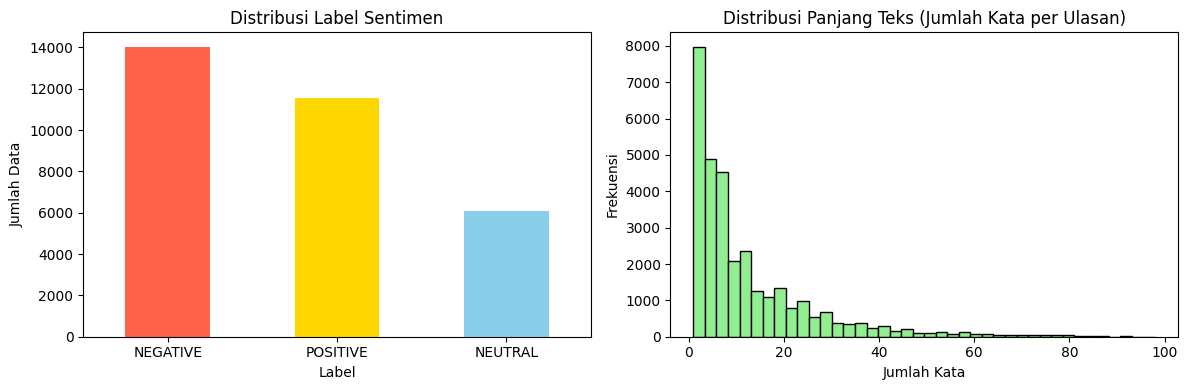

In [80]:
# Membuat dua plot berdampingan
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot kiri: distribusi label
df[COLUMN_LABEL].value_counts().plot(kind="bar", ax=axes[0], color=["tomato", "gold", "skyblue"])
axes[0].set_title("Distribusi Label Sentimen")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Jumlah Data")
axes[0].tick_params(axis='x', rotation=0)

# Plot kanan: distribusi panjang teks
axes[1].hist(df["len_word"], bins=40, color="lightgreen", edgecolor="black")
axes[1].set_title("Distribusi Panjang Teks (Jumlah Kata per Ulasan)")
axes[1].set_xlabel("Jumlah Kata")
axes[1].set_ylabel("Frekuensi")

plt.tight_layout()
plt.show()


Analisis Visualisasi

Grafik kiri menunjukkan bahwa kelas NEGATIVE mendominasi data, sedangkan NEUTRAL memiliki jumlah paling sedikit.
Grafik kanan memperlihatkan sebagian besar ulasan berisi kurang dari 20 kata, menunjukkan teks relatif pendek dan parameter MAX_LEN = 100 sudah sesuai.

**Pembersihan Teks**

Membersihkan teks dari elemen yang tidak relevan seperti URL, mention, angka, dan tanda baca.
Langkah ini penting untuk menyeragamkan format teks sebelum proses tokenisasi.

In [81]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)   # hapus URL
    text = re.sub(r"@\w+|#\w+", " ", text)         # hapus mention & hashtag
    text = re.sub(r"\d+", " ", text)               # hapus angka
    text = text.translate(str.maketrans("", "", string.punctuation))  # hapus tanda baca
    text = re.sub(r"\s+", " ", text).strip()       # rapikan spasi
    return text

df["text_clean"] = df[COLUMN_TEXT].apply(clean_text)
df[["text_clean", COLUMN_LABEL]].head()

,text_clean,sentimen
0,bagus,POSITIVE
1,dana mmg keren mantap,POSITIVE
2,saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,saldo hilang karena no lama hilang ganti no sa...,NEGATIVE


**Encode Label**

Mengonversi label kategori menjadi angka menggunakan LabelEncoder agar dapat digunakan dalam proses pelatihan model.

In [82]:
le = LabelEncoder()
y = le.fit_transform(df[COLUMN_LABEL].values)
num_classes = len(le.classes_)

label_mapping = {i: c for i, c in enumerate(le.classes_)}
print("Mapping label:", label_mapping)

Mapping label: {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}


**Pembagian Data (Train dan Validation)**

Membagi dataset menjadi dua bagian: 80% data latih dan 20% data validasi.
Pembagian dilakukan secara stratified agar proporsi label tetap seimbang.

In [83]:
X_text = df["text_clean"].tolist()

X_train_txt, X_val_txt, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Jumlah data latih:", len(X_train_txt))
print("Jumlah data validasi:", len(X_val_txt))

Jumlah data latih: 25360
Jumlah data validasi: 6341


**Tokenisasi dan Padding**

Mengubah teks menjadi urutan indeks kata dengan Tokenizer, lalu menyamakan panjang tiap teks menggunakan pad_sequences.
Parameter MAX_LEN = 100 dipilih karena panjang teks maksimum dari hasil EDA adalah 98 kata.

In [84]:
MAX_VOCAB = 30000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_txt)

X_train_seq = tokenizer.texts_to_sequences(X_train_txt)
X_val_seq   = tokenizer.texts_to_sequences(X_val_txt)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
print("Vocab size (terpakai):", vocab_size)
print("Shape train:", X_train_pad.shape, "| Shape val:", X_val_pad.shape)

Vocab size (terpakai): 20870
Shape train: (25360, 100) | Shape val: (6341, 100)


**Ringkasan Hasil Pra-proses**

Menampilkan parameter utama hasil praproses yang akan digunakan dalam tahap pembangunan model Transformer.

In [85]:
summary = {
    "Jumlah data latih": len(X_train_pad),
    "Jumlah data validasi": len(X_val_pad),
    "Ukuran vocabulary": vocab_size,
    "Panjang maksimum teks": MAX_LEN,
    "Jumlah kelas": num_classes,
    "Pemetaan label": label_mapping
}
summary

{'Jumlah data latih': 25360,
 'Jumlah data validasi': 6341,
 'Ukuran vocabulary': 20870,
 'Panjang maksimum teks': 100,
 'Jumlah kelas': 3,
 'Pemetaan label': {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}}

**Ringkasan Hasil Pra-proses dan Visualisasi**

Menampilkan parameter utama hasil praproses serta perbandingan jumlah data latih dan validasi dalam bentuk grafik.

{'Jumlah data latih': 25360, 'Jumlah data validasi': 6341, 'Ukuran vocabulary': 20870, 'Panjang maksimum teks': 100, 'Jumlah kelas': 3, 'Pemetaan label': {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}}


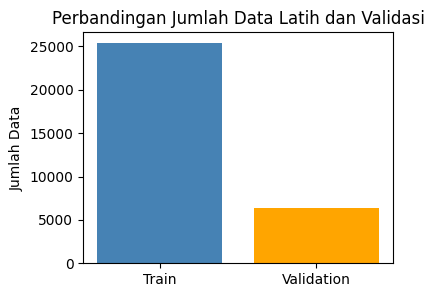

In [86]:
summary = {
    "Jumlah data latih": len(X_train_pad),
    "Jumlah data validasi": len(X_val_pad),
    "Ukuran vocabulary": vocab_size,
    "Panjang maksimum teks": MAX_LEN,
    "Jumlah kelas": num_classes,
    "Pemetaan label": label_mapping
}
print(summary)

# Visualisasi jumlah data train vs validation
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.bar(["Train", "Validation"], [len(X_train_pad), len(X_val_pad)], color=["steelblue", "orange"])
plt.title("Perbandingan Jumlah Data Latih dan Validasi")
plt.ylabel("Jumlah Data")
plt.show()

## **Pembuatan Model Transformer untuk Klasifikasi Sentimen**

Model Transformer dibangun untuk melakukan klasifikasi sentimen tiga kelas menggunakan arsitektur encoder. Komponen utamanya meliputi Embedding Layer, Positional Encoding, Multi-Head Self-Attention, Feed Forward Network, dan Dense Output Layer dengan aktivasi softmax.

Karena dataset berukuran sedang, model dibuat dengan konfigurasi lebih ringan — jumlah layer dan dimensi embedding disesuaikan agar efisien serta mencegah overfitting. Pendekatan ini tetap mewakili konsep dasar Transformer namun tetap realistis untuk sumber daya dan data yang tersedia, sehingga hasilnya dapat dibandingkan secara adil dengan model LSTM dan RNN sebelumnya.

**Implementasi Blok Transformer Encoder**

Bagian ini membangun satu blok Transformer Encoder yang terdiri dari komponen Multi-Head Self-Attention, Feed Forward Network, serta Layer Normalization.
Setiap lapisan menggunakan residual connection agar pelatihan lebih stabil dan informasi dari lapisan sebelumnya tetap terjaga.

In [87]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Self-Attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward
    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x_ff = layers.Dropout(dropout)(x_ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x_ff + x)

    return x

**Arsitektur Model Transformer**

Model ini menggunakan Embedding Layer dan Positional Encoding untuk merepresentasikan urutan kata, kemudian satu blok Transformer Encoder untuk memahami hubungan kontekstual antar kata.
Output dari encoder diringkas dengan Global Average Pooling sebelum melewati Dense Layer untuk klasifikasi tiga kelas sentimen.

In [88]:
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
DROPOUT = 0.2

inputs = layers.Input(shape=(MAX_LEN,))

# Embedding + Positional Encoding
x = layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIM)(inputs)
positions = tf.range(start=0, limit=MAX_LEN, delta=1)
pos_encoding = layers.Embedding(input_dim=MAX_LEN, output_dim=EMBED_DIM)(positions)
x = x + pos_encoding

# Blok Transformer Encoder
x = transformer_encoder(x, head_size=EMBED_DIM, num_heads=NUM_HEADS, ff_dim=FF_DIM, dropout=DROPOUT)

# Global pooling dan output
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 128)  │  2,671,360 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 100, 128)  │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ add_3[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 100, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 128)  │          0 │ dropout_5[0][0],  │
│                     │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100, 128)  │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 100, 128)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 100, 128)  │          0 │ dropout_6[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        387 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,001,987 (11.45 MB)

 Trainable params: 3,001,987 (11.45 MB)

 Non-trainable params: 0 (0.00 B)

**Kompilasi dan Pelatihan Model**

Model dikompilasi menggunakan optimizer Adam dengan laju pembelajaran kecil agar proses pelatihan lebih stabil. Fungsi loss yang digunakan adalah sparse_categorical_crossentropy karena label telah berbentuk numerik hasil LabelEncoder. Metrik utama yang dipantau adalah akurasi.

Pelatihan dilakukan dengan dataset hasil praproses yang sama seperti pada model RNN dan LSTM, tanpa penerapan class weight, agar hasil yang diperoleh dapat dibandingkan secara langsung dan objektif.

In [89]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=64
)

Epoch 1/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 342s 850ms/step - accuracy: 0.5370 - loss: 0.9918 - val_accuracy: 0.6392 - val_loss: 0.7987
Epoch 2/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 312s 786ms/step - accuracy: 0.6779 - loss: 0.7440 - val_accuracy: 0.7321 - val_loss: 0.6496
Epoch 3/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 309s 779ms/step - accuracy: 0.7672 - loss: 0.5515 - val_accuracy: 0.8021 - val_loss: 0.4841
Epoch 4/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 330s 833ms/step - accuracy: 0.8379 - loss: 0.4135 - val_accuracy: 0.8182 - val_loss: 0.4608
Epoch 5/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 311s 785ms/step - accuracy: 0.8698 - loss: 0.3544 - val_accuracy: 0.8188 - val_loss: 0.4794


**Hasil Pelatihan Model Transformer**
Dari hasil pelatihan selama 5 epoch, model Transformer menunjukkan peningkatan performa yang stabil dan konsisten di setiap tahap pelatihan. Akurasi data latih meningkat dari 53.70% pada epoch pertama menjadi 86.98% pada epoch kelima, sementara akurasi validasi naik dari 63.92% menjadi 81.88%. Nilai loss pada data latih menurun dari 0.9918 menjadi 0.3544, sedangkan validation loss turun dari 0.7987 ke 0.4794, menandakan bahwa model berhasil mempelajari pola data dengan baik.
Perbedaan antara training accuracy dan validation accuracy yang kecil menunjukkan bahwa model tidak mengalami overfitting dan memiliki kemampuan generalisasi yang baik terhadap data baru. Pola penurunan loss yang konsisten memperkuat indikasi bahwa proses pembelajaran berlangsung efektif dan stabil.
Secara keseluruhan, hasil ini memperlihatkan bahwa Transformer memberikan performa tinggi dengan arsitektur ringan, melampaui model SimpleRNN dan sebanding dengan LSTM dari tugas sebelumnya, bahkan tanpa penerapan class weight maupun teknik regularisasi tambahan.

**Evaluasi Performa pada Data Validasi**

Mengukur akurasi dan loss akhir pada validation set yang tidak digunakan untuk belajar, lalu menghitung metrik per kelas.

In [92]:
# Evaluasi pada data validasi
val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=0)
print(f"Akurasi Validasi: {val_acc:.4f}")
print(f"Loss Validasi   : {val_loss:.4f}")

Akurasi Validasi: 0.8188
Loss Validasi   : 0.4794


**Prediksi, Confusion Matrix, dan Metrik per Kelas (tanpa import tambahan)**

Menampilkan confusion matrix dan menghitung precision, recall, serta F1-score per kelas menggunakan numpy.

In [94]:
# Prediksi pada validation set
y_val_pred_proba = model.predict(X_val_pad, verbose=0)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Susun confusion matrix (num_classes = jumlah kelas)
K = num_classes
cm = np.zeros((K, K), dtype=int)
for t, p in zip(y_val, y_val_pred):
    cm[t, p] += 1

print("Confusion Matrix (angka):\n", cm)

# Hitung precision, recall, f1 per kelas dari confusion matrix
eps = 1e-12
per_class = []
for c in range(K):
    tp = cm[c, c]
    fp = cm[:, c].sum() - tp
    fn = cm[c, :].sum() - tp

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    support   = cm[c, :].sum()
    per_class.append((precision, recall, f1, support))

try:
    class_names = list(label_encoder.classes_)
except:
    class_names = [f"Class {i}" for i in range(K)]

print("\nPer-class metrics:")
for i, (p, r, f, s) in enumerate(per_class):
    print(f"{class_names[i]:>8} | P={p:.3f} R={r:.3f} F1={f:.3f} (support={s})")

macro_p = np.mean([m[0] for m in per_class])
macro_r = np.mean([m[1] for m in per_class])
macro_f = np.mean([m[2] for m in per_class])
print(f"\nMacro-avg | P={macro_p:.3f} R={macro_r:.3f} F1={macro_f:.3f}")

Confusion Matrix (angka):
 [[2377  234  196]
 [ 321  730  169]
 [ 163   66 2085]]

Per-class metrics:
 Class 0 | P=0.831 R=0.847 F1=0.839 (support=2807)
 Class 1 | P=0.709 R=0.598 F1=0.649 (support=1220)
 Class 2 | P=0.851 R=0.901 F1=0.875 (support=2314)

Macro-avg | P=0.797 R=0.782 F1=0.788


**Interpretasi Hasil Evaluasi Model Transformer**

Hasil confusion matrix menunjukkan performa yang stabil di ketiga kelas sentimen.
Model paling akurat dalam mengenali kelas positif (Class 2) dengan nilai recall tertinggi (0.901) dan F1-score sebesar 0.875, menandakan model sangat baik dalam mendeteksi ulasan positif.
Kinerja pada kelas negatif (Class 0) juga tinggi dengan F1-score 0.839, menandakan kemampuan model dalam membedakan opini negatif secara konsisten.
Namun, kelas netral (Class 1) menunjukkan performa yang lebih rendah (F1-score 0.649), yang berarti model masih kesulitan mengenali sentimen yang ambigu atau cenderung netral — masalah yang juga muncul pada model sebelumnya (RNN dan LSTM).
Nilai rata-rata (macro average) F1 sebesar 0.788 menegaskan bahwa model Transformer memiliki kemampuan generalisasi yang baik, dengan keseimbangan antara presisi dan sensitivitas di semua kelas, bahkan tanpa penggunaan class weight atau penyesuaian tambahan.

**Visualisasi Confusion Matrix**

Visualisasi ini membantu menunjukkan seberapa sering model Transformer berhasil atau gagal dalam mengklasifikasikan tiap sentimen.
Semakin gelap warna diagonal utama (kiri atas ke kanan bawah), semakin banyak prediksi yang benar. Warna di luar diagonal menunjukkan kesalahan klasifikasi antar kelas.

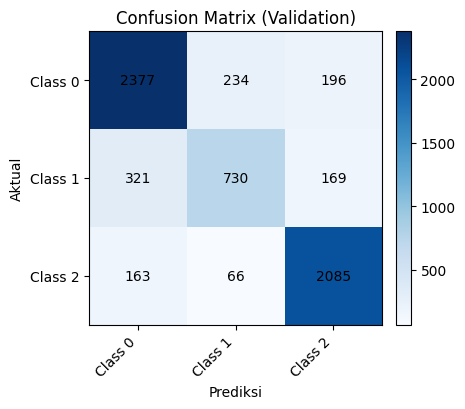

In [95]:
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.colorbar(fraction=0.046, pad=0.04)

plt.xticks(np.arange(K), class_names, rotation=45, ha="right")
plt.yticks(np.arange(K), class_names)

# Tampilkan nilai pada tiap kotak
for i in range(K):
    for j in range(K):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=10)

plt.tight_layout()
plt.show()

**Interpretasi Visual**

Pola warna pada confusion matrix memperlihatkan bahwa prediksi kelas positif dan negatif relatif dominan di diagonal, menandakan akurasi tinggi pada dua kelas tersebut.
Sebaliknya, kelas netral memperlihatkan warna diagonal yang sedikit lebih terang dengan sebaran kesalahan ke kelas negatif maupun positif — ini menunjukkan bahwa model masih sering salah mengira ulasan netral sebagai opini emosional.

Temuan ini selaras dengan hasil F1-score sebelumnya, di mana kelas netral memiliki performa paling rendah dibanding dua kelas lain.

**Pengujian Manual Model Transformer**

Bagian ini digunakan untuk menguji model Transformer secara manual dengan teks baru yang tidak termasuk dalam dataset pelatihan maupun validasi.
Tujuannya adalah untuk melihat kemampuan model dalam mengenali sentimen pada kalimat nyata, terutama yang ditulis secara bebas oleh pengguna.
Melalui pengujian ini, dapat diamati apakah model mampu memberikan prediksi yang konsisten dan masuk akal terhadap kalimat positif, negatif, dan netral, termasuk yang mengandung kata negasi seperti “tidak bagus” atau “kurang menarik”.

In [98]:
# Uji prediksi manual pada teks baru

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+|@\w+|#\w+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Tentukan pemetaan id → label secara robust
try:
    id2label = {i: c for i, c in enumerate(label_encoder.classes_)}  # jika LabelEncoder tersedia
except Exception:
    try:
        # jika ada dict label_mapping: {0:'NEGATIVE', 1:'NEUTRAL', 2:'POSITIVE'}
        id2label = {i: label_mapping[i] for i in range(len(label_mapping))}
    except Exception:
        id2label = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}  # fallback

def predict_manual(texts):
    clean = [clean_text(t) for t in texts]
    seqs = tokenizer.texts_to_sequences(clean)
    X_inf = pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')
    probs = model.predict(X_inf, verbose=0)
    preds = np.argmax(probs, axis=1)

    for t, pr, p in zip(texts, probs, preds):
        probs_str = " | ".join([f"{id2label[i]}={pr[i]:.2f}" for i in range(len(pr))])
        print(f"\nTeks: {t}\nPrediksi: {id2label[p]}\nProbabilitas: {probs_str}")

# Uji prediksi manual dengan variasi konteks dan emosi
predict_manual([
    # Positif eksplisit
    "Aplikasi ini sangat membantu dan mudah digunakan.",
    "Pelayanannya cepat, tampilannya juga menarik!",
    "Sangat puas, semua fitur berfungsi dengan baik.",

    # Negatif eksplisit
    "Sering error saat transaksi, bikin kesal.",
    "Aplikasinya lemot banget dan sering force close.",
    "Saya kecewa, saldo tiba-tiba hilang tanpa alasan.",

    # Netral dan informatif
    "Baru install, belum sempat mencoba fiturnya.",
    "Update versi terbaru kemarin, tampilannya agak beda.",
    "Belum tahu bagus atau tidak, baru pakai sehari.",

    # Campuran (positif + negatif)
    "Fitur-fiturnya lengkap, tapi kadang lambat saat dibuka.",
    "UI bagus tapi performanya masih kurang stabil.",
    "Aplikasinya cukup oke, hanya saja kadang error login.",

    # Ambigu/halus (bisa jadi netral atau positif ringan)
    "Cukup membantu, meskipun kadang tidak terlalu cepat.",
    "Lumayan lah, sesuai ekspektasi tapi belum sempurna.",
    "Tidak buruk, tapi juga belum bisa dibilang bagus."
])



Teks: Aplikasi ini sangat membantu dan mudah digunakan.
Prediksi: POSITIVE
Probabilitas: NEGATIVE=0.00 | NEUTRAL=0.00 | POSITIVE=1.00

Teks: Pelayanannya cepat, tampilannya juga menarik!
Prediksi: POSITIVE
Probabilitas: NEGATIVE=0.00 | NEUTRAL=0.03 | POSITIVE=0.97

Teks: Sangat puas, semua fitur berfungsi dengan baik.
Prediksi: POSITIVE
Probabilitas: NEGATIVE=0.00 | NEUTRAL=0.00 | POSITIVE=1.00

Teks: Sering error saat transaksi, bikin kesal.
Prediksi: NEGATIVE
Probabilitas: NEGATIVE=0.97 | NEUTRAL=0.03 | POSITIVE=0.01

Teks: Aplikasinya lemot banget dan sering force close.
Prediksi: NEGATIVE
Probabilitas: NEGATIVE=0.99 | NEUTRAL=0.00 | POSITIVE=0.01

Teks: Saya kecewa, saldo tiba-tiba hilang tanpa alasan.
Prediksi: NEGATIVE
Probabilitas: NEGATIVE=1.00 | NEUTRAL=0.00 | POSITIVE=0.00

Teks: Baru install, belum sempat mencoba fiturnya.
Prediksi: NEGATIVE
Probabilitas: NEGATIVE=0.59 | NEUTRAL=0.33 | POSITIVE=0.08

Teks: Update versi terbaru kemarin, tampilannya agak beda.
Prediksi: NEGAT

Hasil uji manual menunjukkan bahwa model Transformer mampu mengenali sentimen positif dan negatif secara konsisten, tetapi masih kurang akurat dalam menangani kalimat netral atau ambigu. Kalimat seperti “Aplikasi ini sangat membantu dan mudah digunakan”, “Pelayanannya cepat, tampilannya juga menarik”, dan “Sangat puas, semua fitur berfungsi dengan baik” berhasil diprediksi positif dengan tingkat keyakinan yang sangat tinggi karena mengandung kata seperti “membantu”, “menarik”, dan “puas”. Sementara itu, kalimat negatif seperti “Sering error saat transaksi, bikin kesal” dan “Saya kecewa, saldo tiba-tiba hilang tanpa alasan” juga diklasifikasikan dengan benar karena model peka terhadap kata berkonotasi negatif seperti “error” dan “kecewa”.
Namun, pada kalimat yang seharusnya netral seperti “Baru install, belum sempat mencoba fiturnya” atau “Update versi terbaru kemarin, tampilannya agak beda”, model cenderung memberikan label negatif karena tidak menemukan ekspresi positif yang kuat. Kalimat campuran seperti “UI bagus tapi performanya masih kurang stabil” juga dikategorikan negatif karena bagian negatifnya lebih dominan dalam penilaian model. Bahkan untuk kalimat ambigu seperti “Tidak buruk, tapi juga belum bisa dibilang bagus”, model tetap memutuskan negatif karena fokus pada kata “tidak”.
Secara keseluruhan, model Transformer ini menunjukkan performa yang baik dalam mengenali sentimen eksplisit, tetapi masih kesulitan memahami konteks penyangkalan (negation) dan nuansa netral. Bias negatif ini kemungkinan muncul karena jumlah data netral lebih sedikit pada proses pelatihan, sehingga model belum seimbang dalam menilai pernyataan informatif atau bercampur.

# **Kesimpulan**

Berdasarkan keseluruhan proses dan hasil yang diperoleh, model Transformer untuk klasifikasi sentimen ulasan aplikasi Dana di Google Playstore menunjukkan performa yang solid dan konsisten. Model mampu mencapai akurasi validasi sebesar 81,88% dengan tren pelatihan yang stabil tanpa tanda-tanda overfitting. Nilai macro F1-score sebesar 0.788 mengindikasikan keseimbangan yang baik antara presisi dan recall di seluruh kelas, terutama pada sentimen positif dan negatif yang berhasil diprediksi dengan tingkat akurasi tinggi.
Kinerja terbaik model terlihat pada kelas positif (F1 = 0.875) dan negatif (F1 = 0.839), menunjukkan bahwa Transformer efektif dalam mengenali ekspresi emosional yang eksplisit. Namun, performa pada kelas netral (F1 = 0.649) masih lebih rendah, yang menandakan adanya kecenderungan model untuk menilai ulasan ambigu atau informatif sebagai negatif. Fenomena ini kemungkinan disebabkan oleh ketidakseimbangan jumlah data, di mana kelas netral memiliki porsi yang lebih kecil dibandingkan dua kelas lainnya.
Pengujian manual mendukung temuan ini — model memberikan prediksi yang logis pada kalimat dengan emosi jelas, tetapi masih kesulitan memahami konteks campuran dan negasi seperti “tidak buruk” atau “lumayan”. Secara umum, hasil menunjukkan bahwa Transformer versi ringan yang digunakan dalam proyek ini mampu memberikan performa yang sebanding dengan model LSTM sebelumnya, bahkan tanpa penyesuaian seperti class weight atau regularisasi tambahan.
Dengan demikian, model Transformer terbukti memiliki kemampuan generalisasi yang baik untuk dataset berukuran sedang dan cocok digunakan sebagai baseline kuat dalam klasifikasi sentimen bahasa Indonesia. Untuk peningkatan ke depan, model dapat dikembangkan dengan penyeimbangan data, penambahan layer encoder, atau fine-tuning pretrained model seperti IndoBERT agar lebih sensitif terhadap konteks dan nuansa netral.